<a href="https://colab.research.google.com/github/ravi-gopalan/dog_breed_classifier_udacity/blob/pyt/dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Files

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import random
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFile, Image
import timeit
import time
import copy

In [0]:
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Clone the entire repo.
git_clone_start_time = timeit.default_timer()
!git clone -l -s git://github.com/ravi-gopalan/dog_breed_classifier_udacity.git cloned-repository
%cd cloned-repository
!ls
git_clone_stop_time = timeit.default_timer()
git_clone_time  = git_clone_stop_time - git_clone_start_time
print('git_clone_time: {}'.format(git_clone_time))

Cloning into 'cloned-repository'...
remote: Enumerating objects: 27806, done.
remote: Counting objects: 100% (27806/27806), done.
remote: Compressing objects: 100% (26050/26050), done.
remote: Total 27806 (delta 37), reused 27746 (delta 10), pack-reused 0
Receiving objects: 100% (27806/27806), 1.24 GiB | 55.50 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Checking out files: 100% (21600/21600), done.
/content/cloned-repository
dog_breed_classifier.ipynb	LICENSE
extract_bottleneck_features.py	PyTorch_Transfer_Learning_Exercise.ipynb
haarcascades			README.md
images				sample_cnn.png
lfw				test_images
git_clone_time: 42.79526724800007


# Import Files

In [5]:
os.getcwd()

'/content/cloned-repository'

In [13]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 131351445.85it/s]


In [14]:
use_cuda

True

In [0]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True




def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    img = Image.open(img_path)
    
    transform = transforms.Compose([transforms.Resize(256),\
                                transforms.CenterCrop(224),\
                                transforms.ToTensor(),\
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],\
                                                     std=[0.229, 0.224, 0.225]\
                                                     )\
                                ])
    img_t = transform(img).cuda()
    batch_t = torch.unsqueeze(img_t, 0)
    ## Return the *index* of the predicted class for that image
    VGG16.cuda()
    VGG16.eval()
    out_tensor = VGG16(batch_t)
#    print(out_tensor.shape)
    _, index = torch.max(out_tensor, 1)
#    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    pred = index[0].item()
#    print(pred)


    
    return pred # predicted class index

In [0]:
out = VGG16_predict('/content/cloned-repository/test_images/beagle.jpg')

In [27]:
out

162

###(IMPLEMENTATION) Specify Data Loaders for the Dog Dataset
Use the code cell below to write three separate data loaders for the training, validation, and test datasets of dog images (located at dogImages/train, dogImages/valid, and dogImages/test, respectively). You may find this documentation on custom datasets to be a useful resource. If you are interested in augmenting your training and/or validation data, check out the wide variety of transforms!

In [5]:
images_home = '/content/cloned-repository/images';
images_home

'/content/cloned-repository/images'

In [0]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
# TODO: Define transforms for the training data and testing data
data_transforms = {\
                   'train' : transforms.Compose([\
                                                 transforms.Resize(256),\
                                                 transforms.RandomHorizontalFlip(), # randomly flip and rotate\
                                                 transforms.RandomRotation(10),\
                                                 transforms.RandomResizedCrop(224),\
                                                 transforms.ToTensor(),\
                                                 transforms.Normalize(mean=[0.5,0.5,0.5],\
                                                                      std = [0.5,0.5,0.5])\
                                                 ]),\
                   'valid' : transforms.Compose([\
                                                 transforms.Resize(256),\
                                                 transforms.RandomResizedCrop(224),\
                                                 transforms.ToTensor(),\
                                                 transforms.Normalize(mean=[0.5,0.5,0.5],\
                                                                      std = [0.5,0.5,0.5])\
                                                 ]),\
                   'test' : transforms.Compose([\
                                                 transforms.Resize(256),\
                                                 transforms.RandomResizedCrop(224),\
                                                 transforms.ToTensor(),\
                                                 transforms.Normalize(mean=[0.5,0.5,0.5],\
                                                                      std = [0.5,0.5,0.5])\
                                                 ]),\
                   }

# Reading Dataset
image_datasets = {\
                  'train' : datasets.ImageFolder(images_home + '/train',transform=data_transforms['train']),\
                  'valid' : datasets.ImageFolder(images_home + '/valid',transform=data_transforms['valid']),\
                  'test' : datasets.ImageFolder(images_home + '/test',transform=data_transforms['test'])\
                  }

# Loading Dataset
batch_size=64
data_loaders = {\
                'train' : torch.utils.data.DataLoader(image_datasets['train'],batch_size = batch_size,shuffle=True),\
                'valid' : torch.utils.data.DataLoader(image_datasets['valid'],batch_size = batch_size),\
                'test' : torch.utils.data.DataLoader(image_datasets['test'],batch_size = batch_size)\
                }

In [0]:
dataloaders = {'train': data_loaders['train'], 'valid': data_loaders['valid'], 'test': data_loaders['test']}
dataset_sizes = {'train': len(image_datasets['train']), 'valid': len(image_datasets['valid']), 'test': len(image_datasets['test'])}

In [8]:
classes = image_datasets['train'].classes
num_classes = len(classes)
num_classes

133

In [0]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()


##(IMPLEMENTATION) Model Architecture
Create a CNN to classify dog breed. Use the template in the code cell below.

Question 4: Outline the steps you took to get to your final CNN architecture and your reasoning at each step. 

Answer:

<a id='step4'></a>
# Step 4: Use a CNN to Classify Dog Breeds

In [10]:
# Use GPU if it's available
device = torch.device("cuda" if use_cuda else "cpu")
model = models.resnet50(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 96.4MB/s]


In [11]:
num_ftrs = model.fc.in_features
num_ftrs



2048

In [0]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 256)),
                          ('relu', nn.ReLU()),
                          ('drop',nn.Dropout(0.2)),
                          ('fc2', nn.Linear(256, 133)),
                          ('relu', nn.ReLU()),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

In [28]:
  
model.fc = classifier
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)


model.to(device)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    training_loss = []
    valid_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
              training_loss.append(epoch_loss)
            elif phase == 'valid':
              valid_loss.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    plt.plot(training_loss)
    plt.plot(valid_loss)
    plt.show()
    return model

Epoch 0/49
----------
train Loss: 2.7800 Acc: 0.4838
valid Loss: 2.6496 Acc: 0.5533

Epoch 1/49
----------
train Loss: 2.7617 Acc: 0.4734
valid Loss: 2.5943 Acc: 0.5713

Epoch 2/49
----------
train Loss: 2.7354 Acc: 0.4894
valid Loss: 2.5338 Acc: 0.5820

Epoch 3/49
----------
train Loss: 2.7036 Acc: 0.4868
valid Loss: 2.4999 Acc: 0.5976

Epoch 4/49
----------
train Loss: 2.6831 Acc: 0.4921
valid Loss: 2.4729 Acc: 0.5856

Epoch 5/49
----------
train Loss: 2.6352 Acc: 0.4952
valid Loss: 2.4613 Acc: 0.5796

Epoch 6/49
----------
train Loss: 2.6168 Acc: 0.4978
valid Loss: 2.4799 Acc: 0.5760

Epoch 7/49
----------
train Loss: 2.6058 Acc: 0.5042
valid Loss: 2.4249 Acc: 0.6024

Epoch 8/49
----------
train Loss: 2.6013 Acc: 0.4993
valid Loss: 2.4734 Acc: 0.5964

Epoch 9/49
----------
train Loss: 2.5983 Acc: 0.5066
valid Loss: 2.4354 Acc: 0.5880

Epoch 10/49
----------
train Loss: 2.6018 Acc: 0.4994
valid Loss: 2.4224 Acc: 0.5749

Epoch 11/49
----------
train Loss: 2.5863 Acc: 0.5060
valid Loss

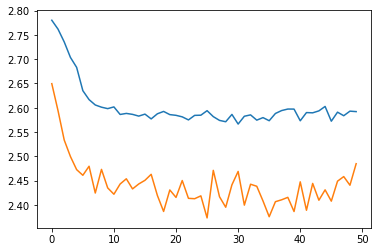

In [30]:
resnet50_tf = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

In [19]:
resnet50_tf.eval()   # Set model to evaluate mode

running_loss = 0.0
running_corrects = 0

# Iterate over data.
for inputs, labels in dataloaders['test']:
  inputs = inputs.to(device)
  labels = labels.to(device)
  
  # zero the parameter gradients
  optimizer.zero_grad()
  outputs = resnet50_tf(inputs)
  _, preds = torch.max(outputs, 1)
  loss = criterion(outputs, labels)

  # statistics
  running_loss += loss.item() * inputs.size(0)
  running_corrects += torch.sum(preds == labels.data)


epoch_loss = running_loss / dataset_sizes['test']
epoch_acc = running_corrects.double() / dataset_sizes['test']
print('\nTest Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


Test Loss: 2.6261 Acc: 0.5670


In [0]:
!mkdir saved_models
torch.save(resnet50_tf.state_dict(), 'saved_models/transfer_resnet50.pt')

In [25]:
model.load_state_dict(torch.load('saved_models/transfer_resnet50.pt'))


<All keys matched successfully>

In [26]:
type(model)

torchvision.models.resnet.ResNet

In [27]:
preds = []
test_check = ['beagle.jpg','labrador_retriever.jpeg','golden_retriever.jpg','great_dane.jpg']

inp_files = ['/content/cloned-repository/test_images/'+x for x in test_check]
img = [Image.open(x) for x in inp_files]
    
transform = transforms.Compose([transforms.Resize(256),\
                                transforms.RandomResizedCrop(224),\
                                transforms.ToTensor(),\
                                transforms.Normalize(mean=[0.5,0.5,0.5],\
                                                     std=[0.5,0.5,0.5]\
                                                     )\
                                ])
batch_t = [torch.unsqueeze(transform(Image.open(x)).cuda(),0) for x in inp_files]

## Return the *index* of the predicted class for that image

if torch.cuda.is_available():
  model.cuda()

model.eval()

for file in inp_files:
  out_tensor = model(torch.unsqueeze(transform(Image.open(file)).cuda(),0))
  #    print(out_tensor.shape)
  _, index = torch.max(out_tensor, 1)
  #    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
  preds.append(classes[index[0].item()])

print(preds)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

['016.Beagle', '070.German_pinscher', '076.Golden_retriever', '041.Bullmastiff']


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

(tensor([-0.5849], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([15], device='cuda:0'))

In [33]:
pred = classes[index[0].item()]
pred

15

In [35]:
classes[15]

'016.Beagle'

In [0]:
# move model to GPU if CUDA is available
if torch.cuda.is_available():
    resnet34 = model.cuda()

In [98]:
type(resnet34)

torchvision.models.resnet.ResNet

**Predict Dog Breed with the Model**

In [0]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

<a id='step5'></a>
# Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

**Step 5a:**
You will now use transfer learning to create a CNN that can identify dog breed from images. Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features. In this section, you must use the bottleneck features from a different pre-trained model. To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:
> Dog{network}Data.npz

where {network}, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`. Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

**Obtain Bottleneck Features**
---
In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

`bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')`

`train_{network} = bottleneck_features['train']`

`valid_{network} = bottleneck_features['valid']`

`test_{network} = bottleneck_features['test']`

### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [0]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def VGG19_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


def Inception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [0]:
print('git_clone_time: {}'.format(git_clone_time))
print('Tensor Creation Time: '.format(model_tensor_creation_time))
print('Model Loading Time: {}'.format(model_load_time))
print('Model Training Time')
print('VGG19 : {}'.format(model_fit_time_VGG19))
print('Resnet50 : {}'.format(model_fit_time_Resnet50))
print('Inception : {}'.format(model_fit_time_Inception))
print('Xception : {}'.format(model_fit_time_Xception))

git_clone_time: 47.49244925599987
Tensor Creation Time: 
Model Loading Time: 159.5862713749998
Model Training Time
VGG19 : 24.00138351700025
Resnet50 : 18.335568986999988
Inception : 31.196043481999823
Xception : 44.72935781900014


# Step 5b: Use Fast.AI to create a model and provide predictions

In [0]:
data = (ImageList.from_folder(image_dir)
        .split_by_folder()          
        .label_from_folder()
        .transform(get_transforms(do_flip=False), size=224)
        .databunch(bs=32)
        .normalize(imagenet_stats))

len(data.classes)

133

In [0]:
learn_resnet34 = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 84732137.37it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


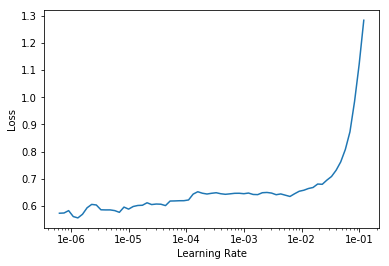

In [0]:
learn_resnet34.fit_one_cycle(2)
learn_resnet34.save('stage_1_resnet34')
# Find out learning rate
learn_resnet34.lr_find()
# Plot learning rate
learn_resnet34.recorder.plot()

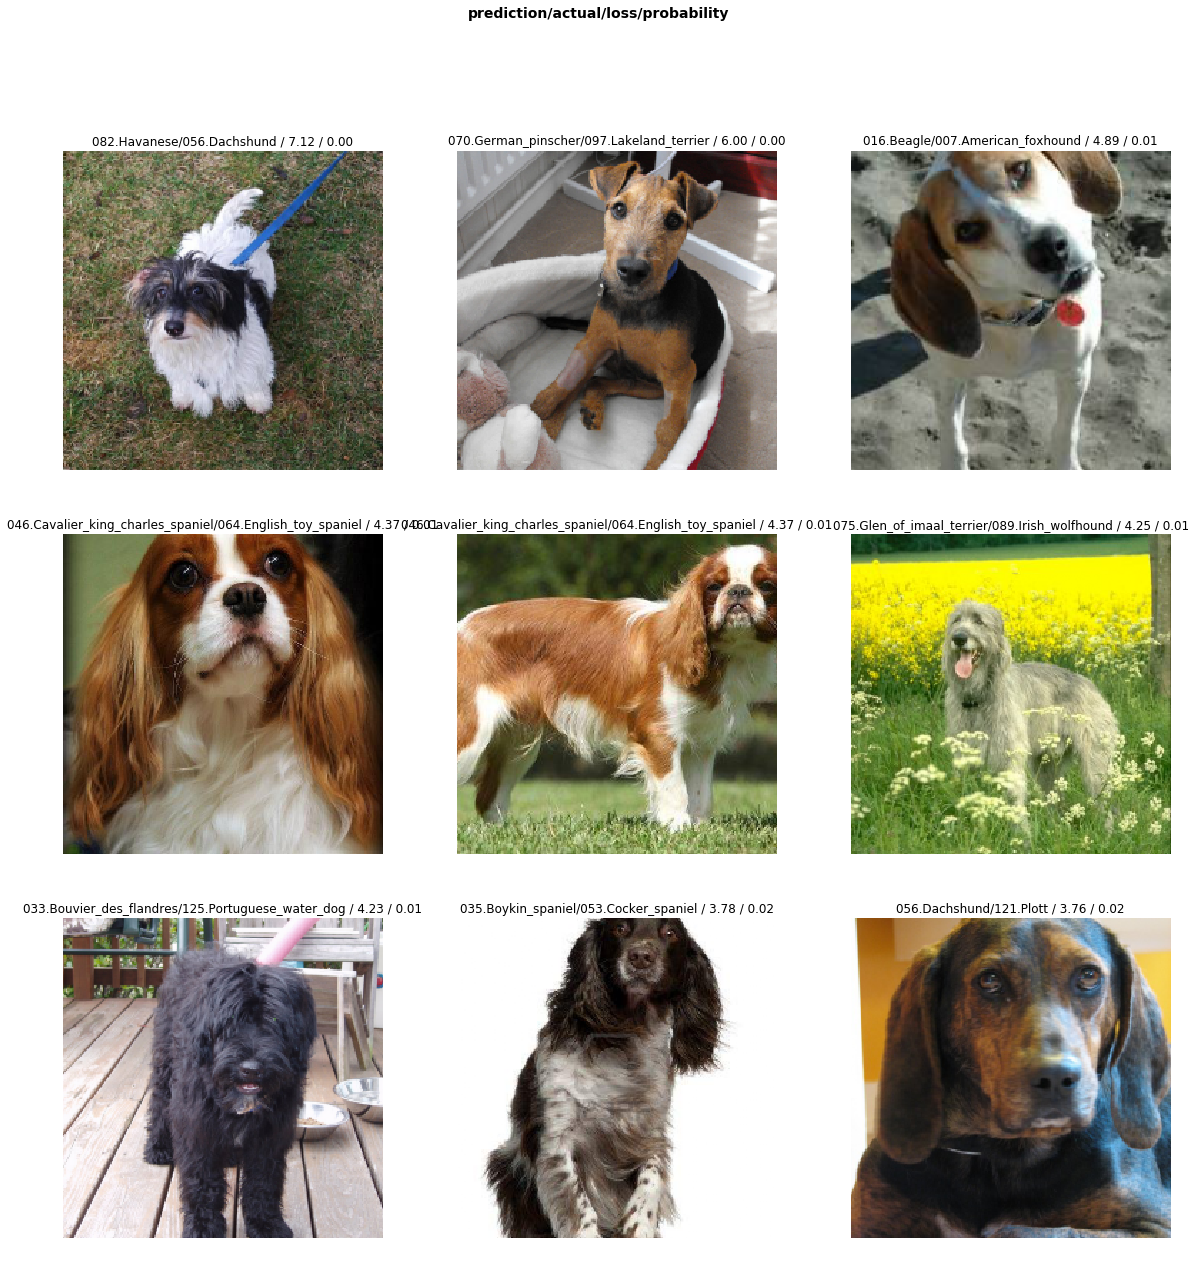

In [0]:
interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet34)
interp_resnet34.plot_top_losses(9, figsize=(20,20))

In [0]:
learn_resnet34.unfreeze()
learn_resnet34.fit_one_cycle(10, max_lr = slice(1e-6,1e-3))

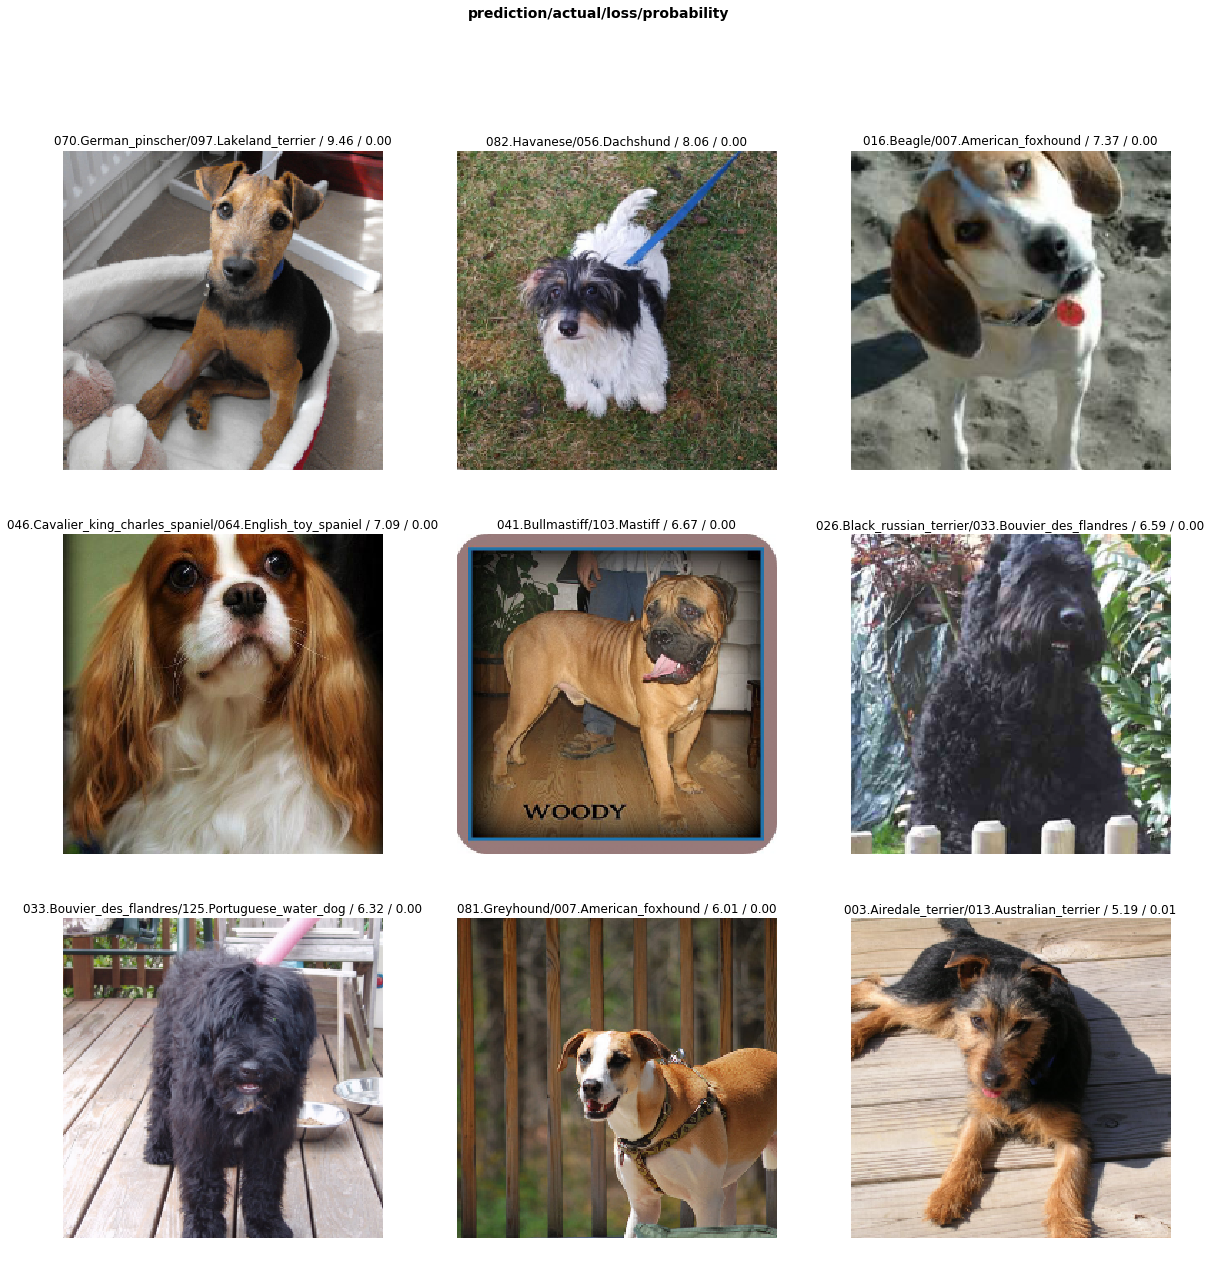

In [0]:
interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet34)
interp_resnet34.plot_top_losses(9, figsize=(20,20))

In [0]:
learn_resnet34.save('stage_2_resnet34')
learn_resnet34.export('/content/cloned-repository/saved_models/learn_resnet34.pkl')

<a id='step6'></a>
# Step 6: Write own algorithm to provide an output breed based on an image

## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  


### Write your Algorithm

In [0]:
algo_sample_files = np.array(glob(os.path.join(basedir,'test_images/*')))
algo_sample_files

array(['/content/cloned-repository/test_images/pele.jpg', '/content/cloned-repository/test_images/beagle.jpg',
       '/content/cloned-repository/test_images/rajapalayam.jpg',
       '/content/cloned-repository/test_images/virat_kohli.jpg',
       '/content/cloned-repository/test_images/labrador_retriever.jpeg',
       '/content/cloned-repository/test_images/pomeranian.jpg',
       '/content/cloned-repository/test_images/golden_retriever.jpg',
       '/content/cloned-repository/test_images/great_dane.jpg'], dtype='<U62')

In [0]:
def predict_breed(file_path):
  predicted_dog_breed, tensor_index, probability_tensor = learn_resnet34.predict(open_image(file_path))
  return predicted_dog_breed

def algo(img):
    if dog_detector(img):
        species = 'dog'              
        output = predict_breed(img)
    elif face_detector(img):
        species = 'human'
        output = predict_breed(img)
    else:
        species = 'Neither dog nor human'
        output = 'Error'
    return species, output

def provide_output(input_path):
    species, breed = algo(input_path)
    #print(species, breed)
    print('Hello! {}'.format(species))
   
    if str(breed) != 'Error':
        print('You look like {}'.format(str(breed)[4:]))
#    print(breed)
    else:
        print('Error: Unable to identify breed')   

The `predict_breed` function outputs the breed of the dog given an input of a filepath. 

The `algo` function determines if the provided file_path contains a dog or human or neither and returns the species (dog or human or neither) and the  predicted breed of the image

The `provide_output` outputs a greeting based on the predicted species and dog breed 

# Step 7: Test Your Algorithm

Hello! human
You look like Dogue_de_bordeaux


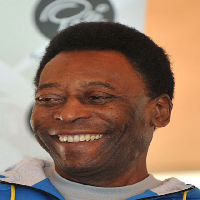

Hello! dog
You look like Beagle


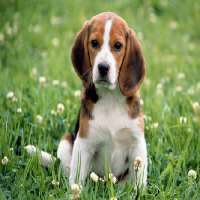

Hello! dog
You look like Ibizan_hound


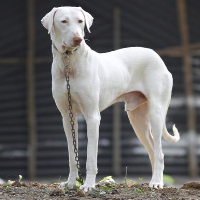

Hello! human
You look like Affenpinscher


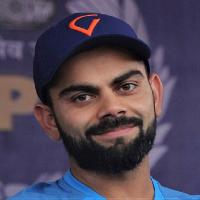

Hello! dog
You look like Labrador_retriever


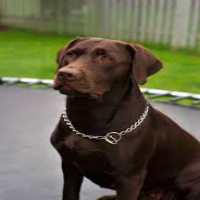

Hello! dog
You look like Pomeranian


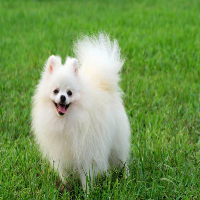

Hello! dog
You look like Golden_retriever


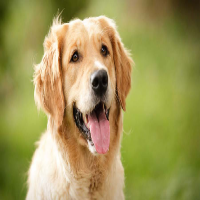

Hello! dog
You look like Great_dane


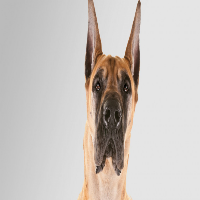

In [0]:
 for item in algo_sample_files:
   provide_output(item)
   open_image(item).resize(200)


tensor([2.5701e-02, 6.2279e-04, 2.9742e-04, 1.6232e-03, 2.0206e-03, 1.5713e-02,
        5.9746e-04, 9.9776e-04, 6.3507e-03, 7.0878e-05, 2.6578e-03, 2.3682e-02,
        9.1015e-04, 2.9092e-03, 9.5743e-04, 3.4704e-03, 3.6873e-03, 3.4477e-02,
        2.0255e-04, 9.6921e-04, 8.9684e-03, 1.0505e-02, 3.8697e-02, 1.5283e-03,
        2.9311e-03, 1.0937e-03, 1.5749e-03, 2.8864e-04, 1.3219e-03, 7.9451e-03,
        2.0587e-03, 4.4418e-04, 3.7401e-02, 2.1049e-02, 7.0180e-04, 4.9624e-04,
        8.8061e-03, 9.0434e-04, 5.5815e-03, 1.6520e-03, 3.5833e-03, 5.3652e-04,
        3.2357e-04, 3.7811e-03, 7.1186e-03, 1.0206e-02, 2.8859e-03, 2.4326e-02,
        1.7116e-03, 1.3880e-04, 8.9626e-04, 2.6350e-03, 1.8776e-04, 1.7157e-02,
        8.3694e-04, 1.3226e-03, 4.9110e-03, 1.9943e-03, 1.1327e-02, 4.5343e-02,
        2.4982e-04, 3.1035e-04, 1.0842e-03, 9.5867e-03, 1.2895e-03, 8.9388e-04,
        4.0547e-03, 2.4221e-02, 2.6306e-02, 2.9866e-04, 1.3000e-03, 8.5516e-04,
        3.6509e-04, 7.5063e-04, 3.6966e-

'Roger_Moore/Roger_Moore_0001.jpg'

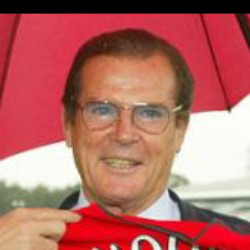

'Nova_scotia_duck_tolling_retriever'

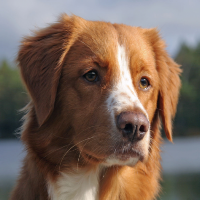

In [0]:
x = human_files[6030]

predicted_dog_breed, tensor_index, probability_tensor = learn_resnet34.predict(open_image(x))
probability_tensor
print('\n')
x.lstrip('/content/cloned-repository/lfw/')
print('\n')
open_image(x)
print('\n')
str(predicted_dog_breed)[4:]
print('\n')
open_image(sorted(Path(train_dir,str(predicted_dog_breed)).glob('*.jpg'))[-1]).resize(200)